In [4]:
# !pip install scikit-uplift catboost
# pip install pycausalimpact
# pip install -U DoubleML

In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'
REGION = "us-central1"

# VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com'
VERTEX_SA = 'jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")
print(f"REGION: {REGION}")
print(f"VERTEX_SA: {VERTEX_SA}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1
REGION: us-central1
VERTEX_SA: jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com


In [2]:
REGION = 'us-central1'
EXPERIMENT = 'control_group1'
SERIES = 'causal_impact_4'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

BQ_SOURCE1 = 'bigquery-public-data.new_york.citibike_trips'
BQ_SOURCE2 = 'bigquery-public-data.new_york.citibike_stations'

viz_limit = 12

### packages & client SDK

In [3]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns

# Causal impact
from causalimpact import CausalImpact

# from uplift_utils import 
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds

from google.cloud import aiplatform as vertex_ai

bq = bigquery.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID, 
    location=REGION,
    # credentials=credentials
)

## Test Set Predictions 

In [4]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = [
    'avg_tripduration', 
    'pct_subscriber', 
    'ratio_gender', 
    'capacity'
] # could be empty

BQ_TABLE_GROUP_A="control_group1_grp_a"
BQ_TABLE_GROUP_B="control_group1_grp_b"

GROUP_A_PREDS_BQ_URI=f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_A}_pred_Test'
GROUP_B_PREDS_BQ_URI=f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_B}_pred_Test'

print(f"GROUP_A_PREDS_BQ_URI: {GROUP_A_PREDS_BQ_URI}")
print(f"GROUP_B_PREDS_BQ_URI: {GROUP_B_PREDS_BQ_URI}")

GROUP_A_PREDS_BQ_URI: hybrid-vertex.causal_impact_4.control_group1_grp_a_pred_Test
GROUP_B_PREDS_BQ_URI: hybrid-vertex.causal_impact_4.control_group1_grp_b_pred_Test


In [5]:
query = f"""
    SELECT * 
    FROM `{GROUP_A_PREDS_BQ_URI}`
    ORDER BY starttime ASC;
"""
groupa_test_preds = bq.query(query = query).to_dataframe()

groupa_test_preds['residuals'] = groupa_test_preds['num_trips'] - groupa_test_preds['predicted_num_trips']

groupa_test_preds = groupa_test_preds.rename(columns={'predicted_num_trips': 'a_predicted_num_trips', 'residuals': 'a_residuals'})
# groupa_test_preds.columns = 'a_' + groupa_test_preds.columns

print(f"Shape: {groupa_test_preds.shape}")
groupa_test_preds.head(10)

Shape: (208, 9)


,a_predicted_num_trips,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,start_station_name,a_residuals
0,-12.221727,2016-07-23,8,867.750000,0.875000,3.000000,23,Marcy Ave & Lafayette Ave,20.221727
1,-5.718968,2016-07-23,28,738.000000,0.928571,4.600000,27,Lafayette Ave & Classon Ave,33.718968
2,29.382119,2016-07-23,19,759.736842,0.842105,2.166667,39,Lafayette Ave & St James Pl,-10.382119
3,62.312957,2016-07-23,44,786.636364,0.727273,0.833333,51,Clermont Ave & Lafayette Ave,-18.312957
4,-8.922878,2016-07-24,18,968.777778,0.944444,1.250000,23,Marcy Ave & Lafayette Ave,26.922878
5,30.613588,2016-07-24,26,631.115385,0.846154,1.600000,39,Lafayette Ave & St James Pl,-4.613588
6,-22.154098,2016-07-25,11,12164.818182,0.909091,4.500000,23,Marcy Ave & Lafayette Ave,33.154098
7,-1.082576,2016-07-25,24,1065.833333,0.833333,2.428571,27,Lafayette Ave & Classon Ave,25.082576
8,-7.983626,2016-07-26,20,837.900000,0.850000,1.000000,23,Marcy Ave & Lafayette Ave,27.983626
9,-5.964148,2016-07-26,34,660.382353,0.970588,4.666667,27,Cumberland St & Lafayette Ave,39.964148


In [6]:
query = f"""
    SELECT * 
    FROM `{GROUP_B_PREDS_BQ_URI}`
    ORDER BY starttime ASC;
"""
groupb_test_preds = bq.query(query = query).to_dataframe()

groupb_test_preds['residuals'] = groupb_test_preds['num_trips'] - groupb_test_preds['predicted_num_trips']

groupb_test_preds = groupb_test_preds.rename(columns={'predicted_num_trips': 'b_predicted_num_trips', 'residuals': 'b_residuals'})
# groupb_test_preds.columns = 'b_' + groupb_test_preds.columns

print(f"Shape: {groupb_test_preds.shape}")
groupb_test_preds.head(10)

Shape: (255, 9)


,b_predicted_num_trips,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,start_station_name,b_residuals
0,-52.023356,2016-07-23,32,822.656250,0.875000,1.666667,0,Lafayette Ave & Fort Greene Pl,84.023356
1,6.261190,2016-07-23,45,612.688889,0.933333,1.250000,27,Cumberland St & Lafayette Ave,38.73881
2,-49.030197,2016-07-24,39,1334.333333,0.794872,0.772727,0,Lafayette Ave & Fort Greene Pl,88.030197
3,5.785577,2016-07-24,23,783.391304,0.913043,1.875000,27,Lafayette Ave & Classon Ave,17.214423
4,5.987348,2016-07-24,26,537.500000,0.923077,1.600000,27,Cumberland St & Lafayette Ave,20.012652
5,63.452991,2016-07-24,19,607.368421,0.736842,0.900000,51,Clermont Ave & Lafayette Ave,-44.452991
6,-51.130414,2016-07-25,31,1037.161290,0.838710,1.583333,0,Lafayette Ave & Fort Greene Pl,82.130414
7,5.322646,2016-07-25,28,801.107143,0.892857,2.500000,27,Cumberland St & Lafayette Ave,22.677354
8,28.164222,2016-07-25,21,793.333333,1.000000,3.200000,39,Lafayette Ave & St James Pl,-7.164222
9,57.676542,2016-07-25,25,630.640000,0.920000,2.125000,51,Clermont Ave & Lafayette Ave,-32.676542


### group by station name

In [7]:
a_df = groupa_test_preds.groupby('start_station_name').agg(
    a_pred_sum=pd.NamedAgg(column="a_predicted_num_trips", aggfunc="sum")
).reset_index()
# a_df.head(3)

b_df = groupb_test_preds.groupby('start_station_name').agg(
    b_pred_sum=pd.NamedAgg(column="b_predicted_num_trips", aggfunc="sum")
).reset_index()
b_df.head(3)

,start_station_name,a_pred_sum
0,Clermont Ave & Lafayette Ave,1785.538084
1,Cumberland St & Lafayette Ave,-24.806472
2,Lafayette Ave & Classon Ave,-18.876421


# merge & calculate incremental difference

In [9]:
new_df = pd.merge(a_df, b_df,  how='left', left_on='start_station_name', right_on ='start_station_name')

new_df['incremental_b'] = new_df['b_pred_sum'] - new_df['a_pred_sum']

new_df

,start_station_name,a_pred_sum,b_pred_sum,incremental_b
0,Clermont Ave & Lafayette Ave,1785.538084,2339.678094,554.140010
1,Cumberland St & Lafayette Ave,-24.806472,193.382301,218.188773
2,Lafayette Ave & Classon Ave,-18.876421,167.054322,185.930743
3,Lafayette Ave & Fort Greene Pl,-2145.398416,-1970.228071,175.170345
4,Lafayette Ave & St James Pl,963.411110,1207.991062,244.579952
5,Lafayette St & E 8 St,795.121880,1173.510689,378.388809
6,Lafayette St & Jersey St,899.289054,1747.289176,848.000121
7,Marcy Ave & Lafayette Ave,-392.276526,-59.367348,332.909177


# Visualize series

In [12]:
BQ_DATASET = 'causal_impact_4'
BQ_TABLE_GROUP_A="control_group1_grp_a"
BQ_TABLE_GROUP_B="control_group1_grp_b"

## get train & valid data

In [13]:
query = f"""
    SELECT * 
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_A}`
    WHERE splits in ('TRAIN','VALIDATE')
    ORDER BY starttime ASC;
"""
groupa_train = bq.query(query = query).to_dataframe()
groupa_train.head(2)

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,splits,control_group
0,Lafayette St & E 8 St,2013-07-01,138,726.391304,0.869565,1.76,91,TRAIN,Group_A
1,Lafayette Ave & St James Pl,2013-07-01,10,643.800000,0.900000,1.50,39,TRAIN,Group_A


In [14]:
query = f"""
    SELECT * 
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_B}`
    WHERE splits in ('TRAIN','VALIDATE')
    ORDER BY starttime ASC;
"""
groupb_train = bq.query(query = query).to_dataframe()
groupb_train.head(2)

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,splits,control_group
0,Lafayette St & Jersey St,2013-07-01,51,794.098039,0.745098,1.428571,60,TRAIN,Group_B
1,Lafayette Ave & Classon Ave,2013-07-01,10,614.900000,1.000000,9.000000,27,TRAIN,Group_B


In [15]:
test_b_df=groupb_test_preds.set_index('starttime')
test_a_df=groupa_test_preds.set_index('starttime')

test_a_df['control_grp'] = 'Group_A'
test_b_df['control_grp'] = 'Group_B'

test_a_df=test_a_df.rename(columns={"a_predicted_num_trips":"predicted_num_trips","a_residuals":"residuals"})
test_b_df=test_b_df.rename(columns={"b_predicted_num_trips":"predicted_num_trips","b_residuals":"residuals"})

print(f"test_b_df shape: {test_b_df.shape}")
print(f"test_a_df shape: {test_a_df.shape}")

test_a_df.head(2)

test_b_df shape: (255, 9)
test_a_df shape: (208, 9)


,predicted_num_trips,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,start_station_name,residuals,control_grp
starttime,,,,,,,,,
2016-07-23,-12.221727,8,867.75,0.875000,3.0,23,Marcy Ave & Lafayette Ave,20.221727,Group_A
2016-07-23,-5.718968,28,738.00,0.928571,4.6,27,Lafayette Ave & Classon Ave,33.718968,Group_A


In [16]:
test_a_df.shape[0]

208

In [19]:
frames = [test_b_df,test_a_df]

combined_df = pd.concat(frames)

print(f"combined_df shape: {combined_df.shape}")
print(f"expected rows    :  {test_a_df.shape[0]+test_b_df.shape[0]}")
combined_df.head(2)

combined_df shape: (463, 9)
expected rows    :  463


,predicted_num_trips,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,start_station_name,residuals,control_grp
starttime,,,,,,,,,
2016-07-23,-52.023356,32,822.656250,0.875000,1.666667,0,Lafayette Ave & Fort Greene Pl,84.023356,Group_B
2016-07-23,6.261190,45,612.688889,0.933333,1.250000,27,Cumberland St & Lafayette Ave,38.73881,Group_B


### get key dates

In [45]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 7 #14
forecast_test_length = 70
forecast_val_length = 70

In [46]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date,
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_B}`  
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-05-14,2016-07-23,2016-09-30


## plot time series

In [57]:
# group_a_series = combined_df.query("control_grp == 'Group_A'")
# group_b_series = combined_df.query("control_grp == 'Group_B'")

# # test_a_df['control_grp'] = 'Group_A'

# # Visualize data using seaborn
sns.set(rc={'figure.figsize':(10,4)})
# sns.lineplot(x=groupa_train.starttime, y=groupa_train[TARGET_COLUMN], legend='auto')
# sns.lineplot(x=groupb_train.starttime, y=groupb_train[TARGET_COLUMN], legend='auto')
# sns.lineplot(x=group_a_series.index, y=group_a_series[TARGET_COLUMN], legend='auto')
# sns.lineplot(x=group_b_series.index, y=group_b_series[TARGET_COLUMN], legend='auto');
# # plt.legend(labels = ['NYC', 'AUSTIN']);

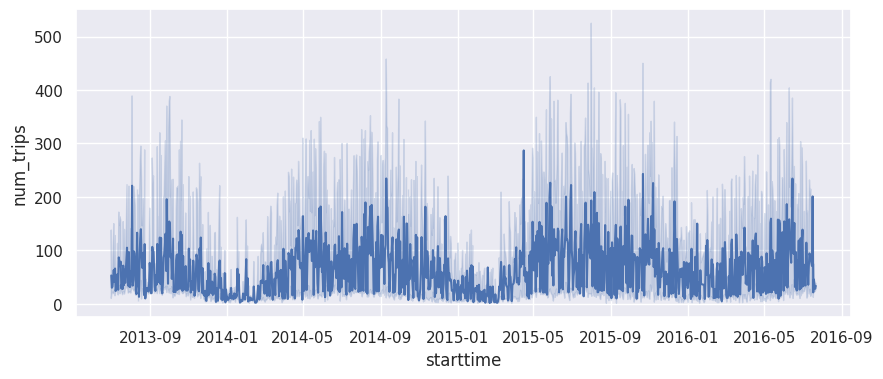

In [58]:
sns.lineplot(x=groupa_train.starttime, y=groupa_train[TARGET_COLUMN], legend='auto');

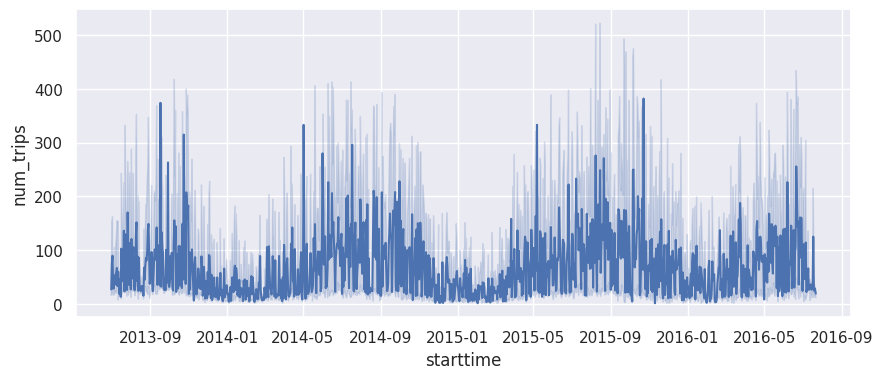

In [59]:
sns.lineplot(x=groupb_train.starttime, y=groupb_train[TARGET_COLUMN], legend='auto');

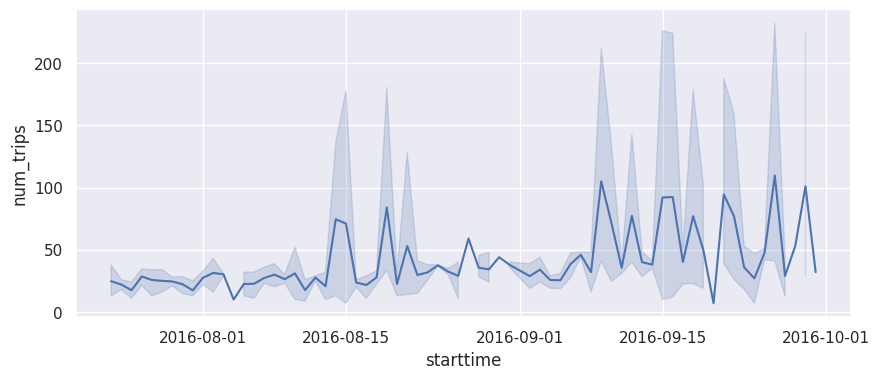

In [60]:
sns.lineplot(x=group_a_series.index, y=group_a_series[TARGET_COLUMN], legend='auto');

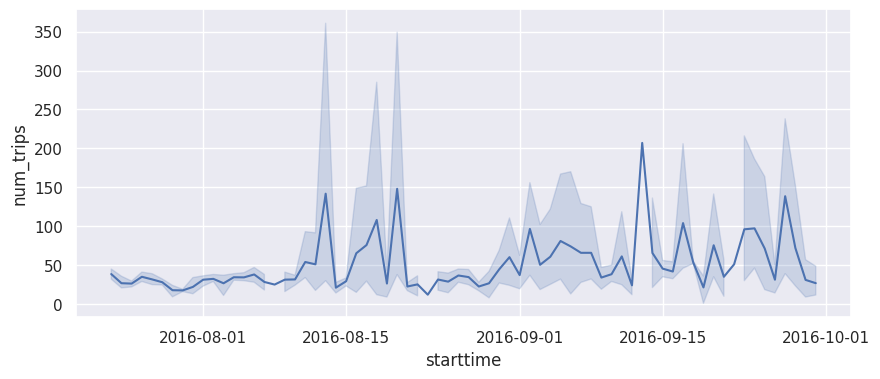

In [61]:
sns.lineplot(x=group_b_series.index, y=group_b_series[TARGET_COLUMN], legend='auto');

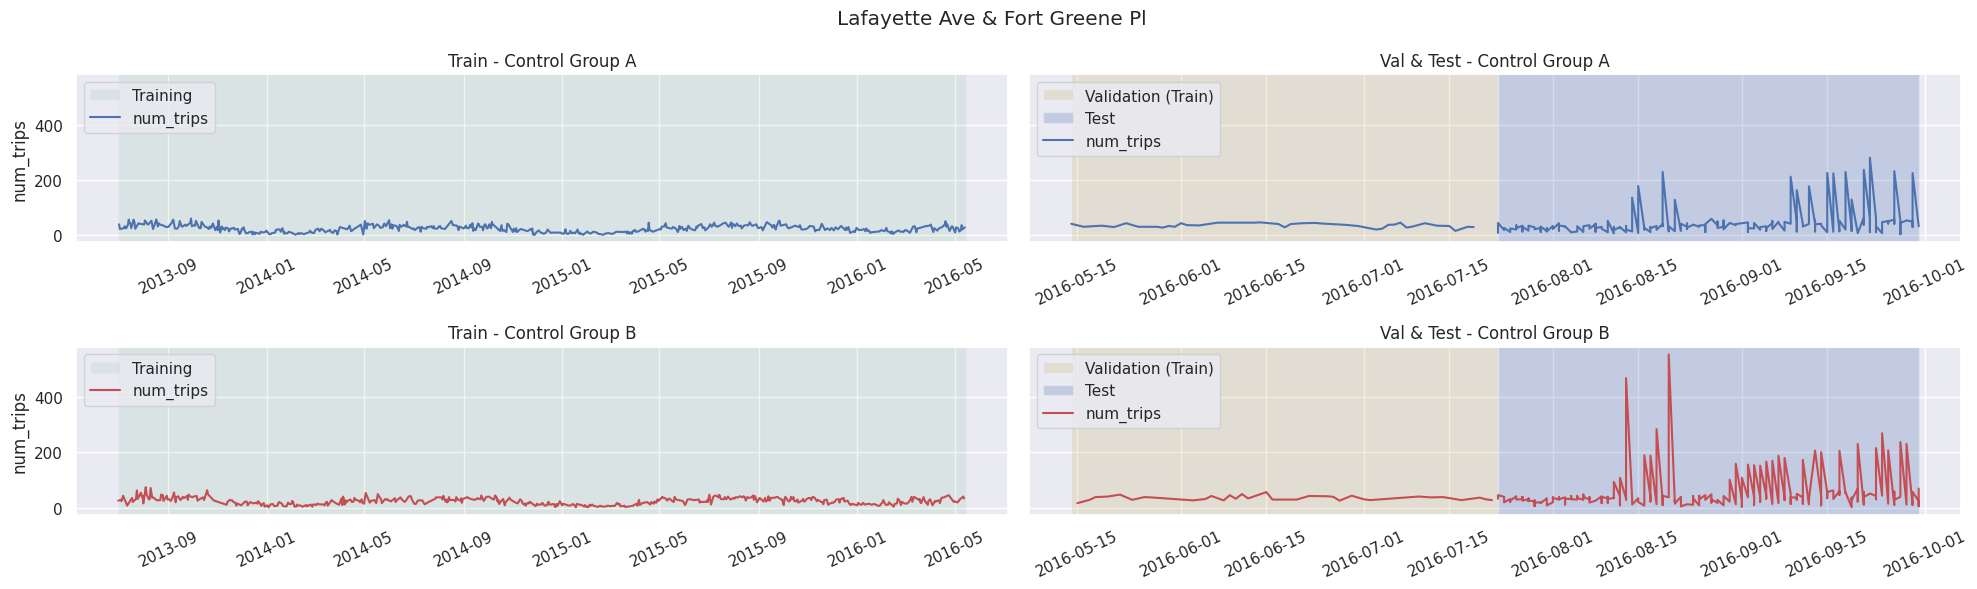

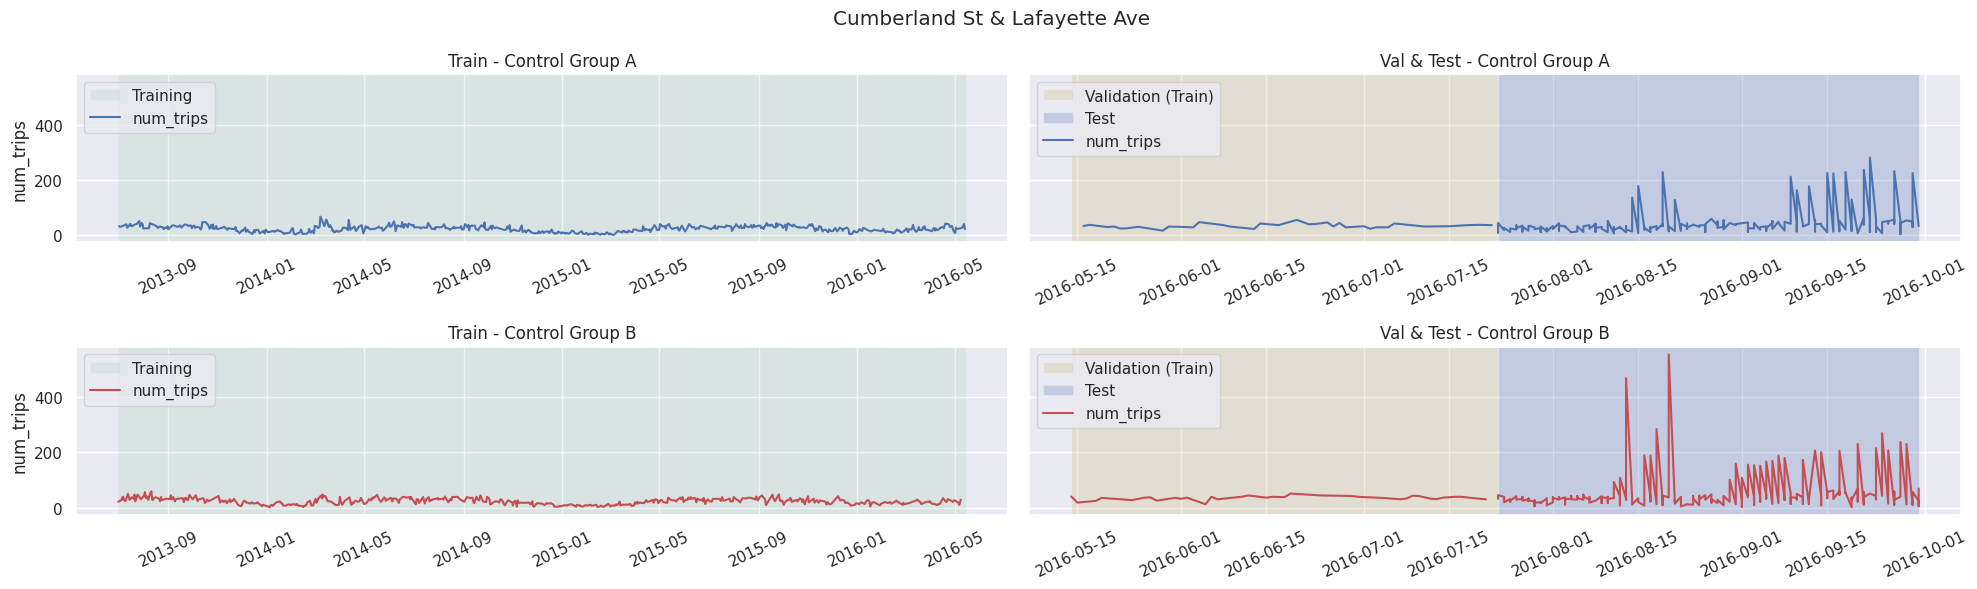

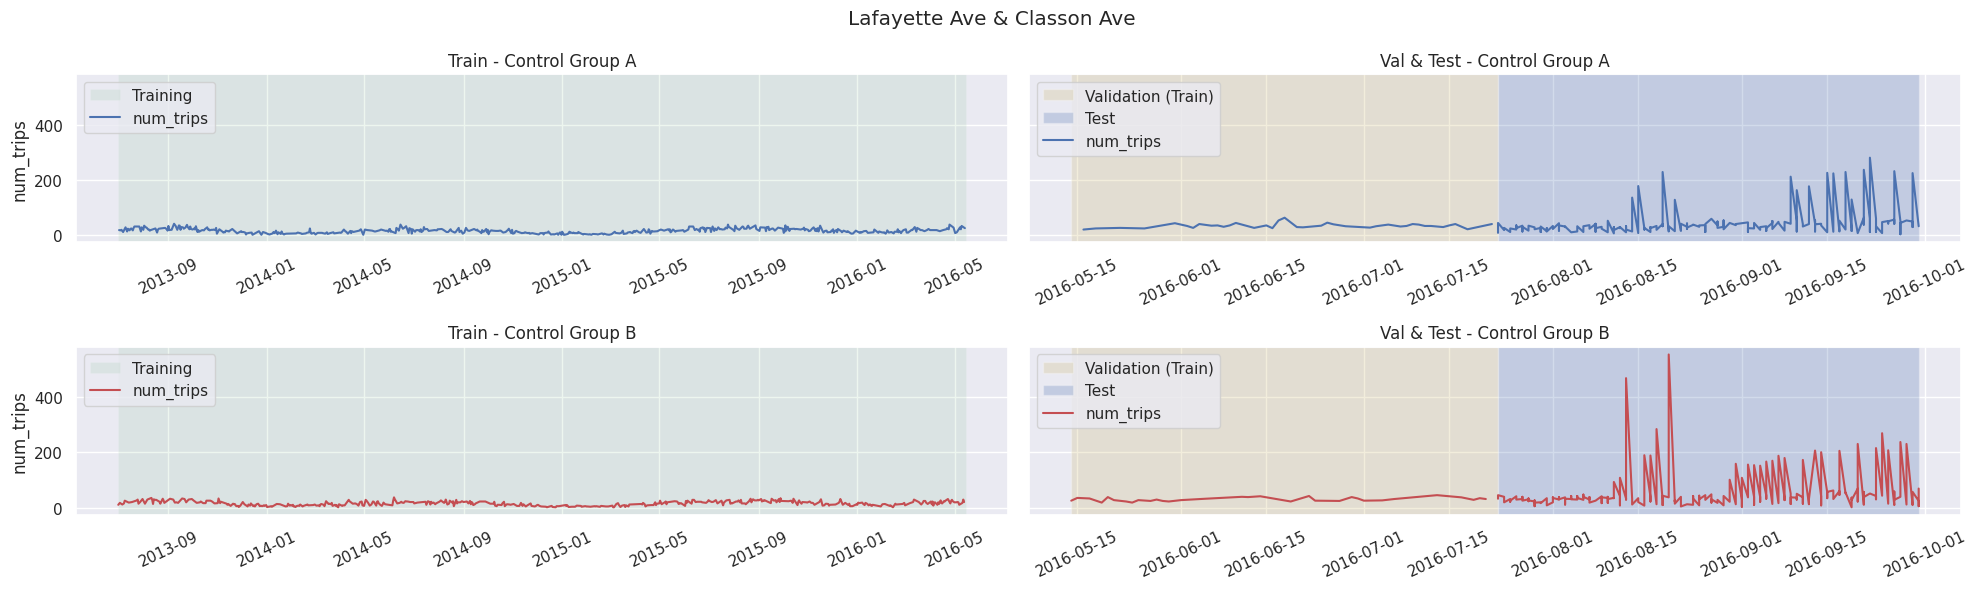

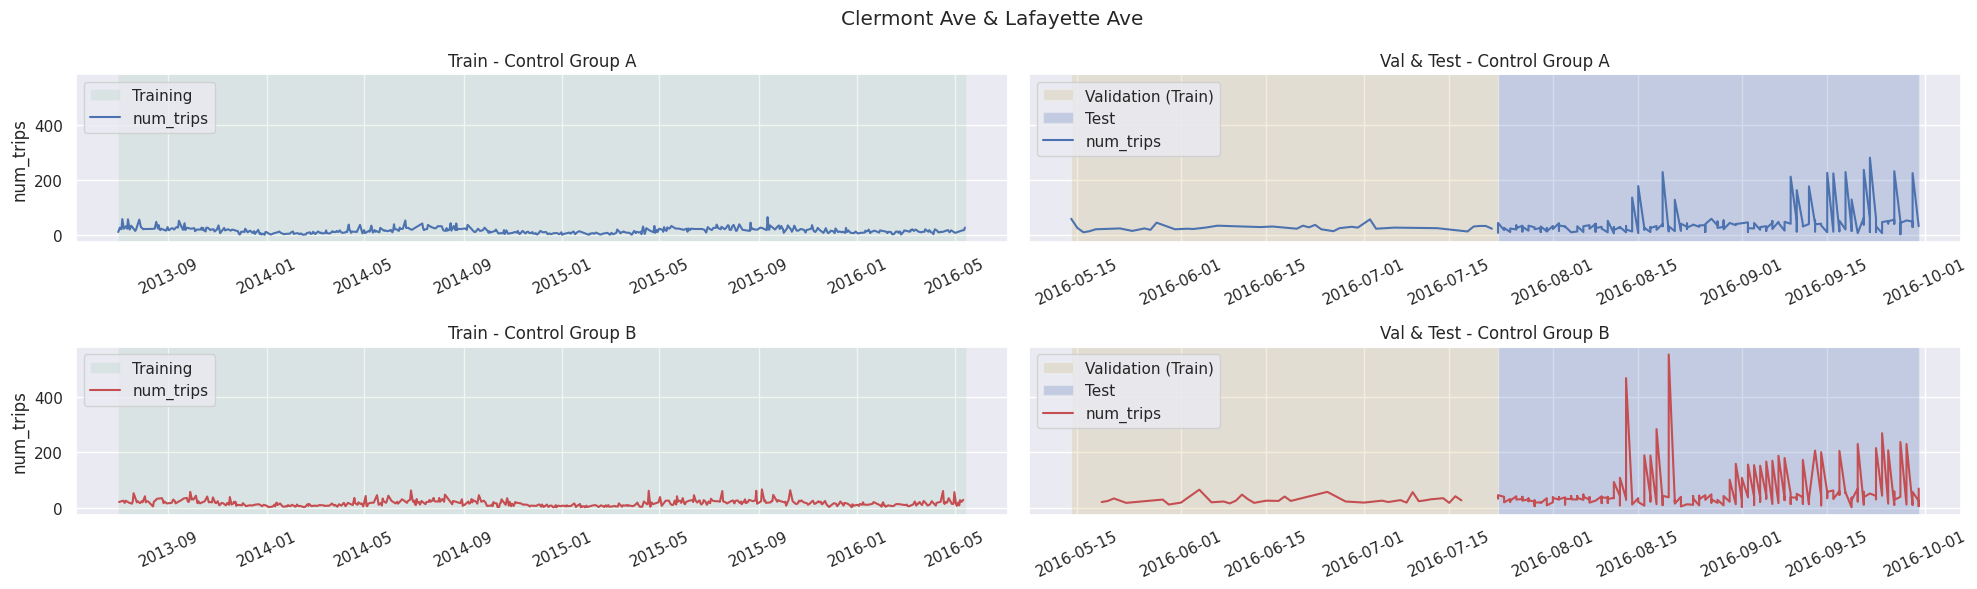

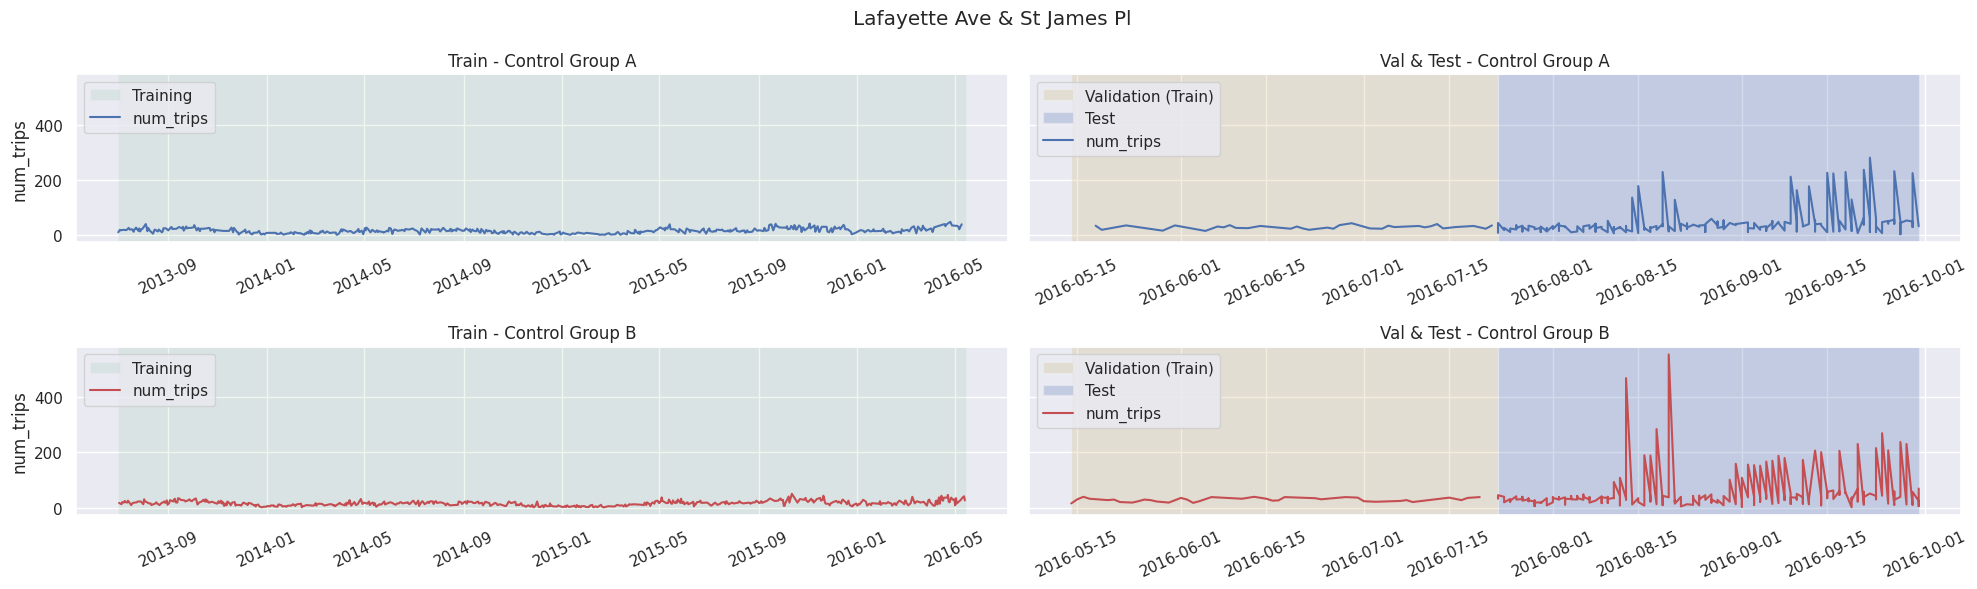

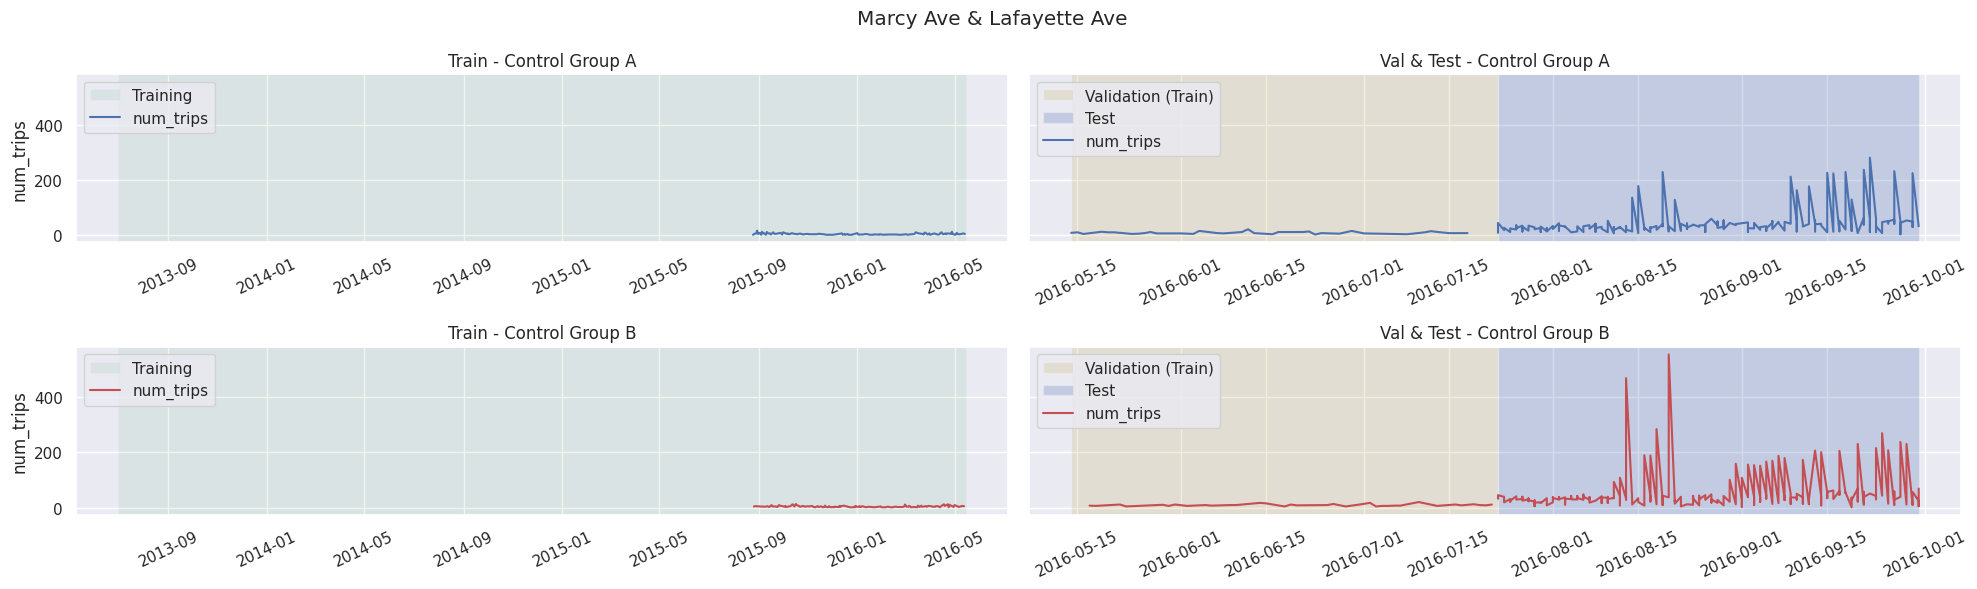

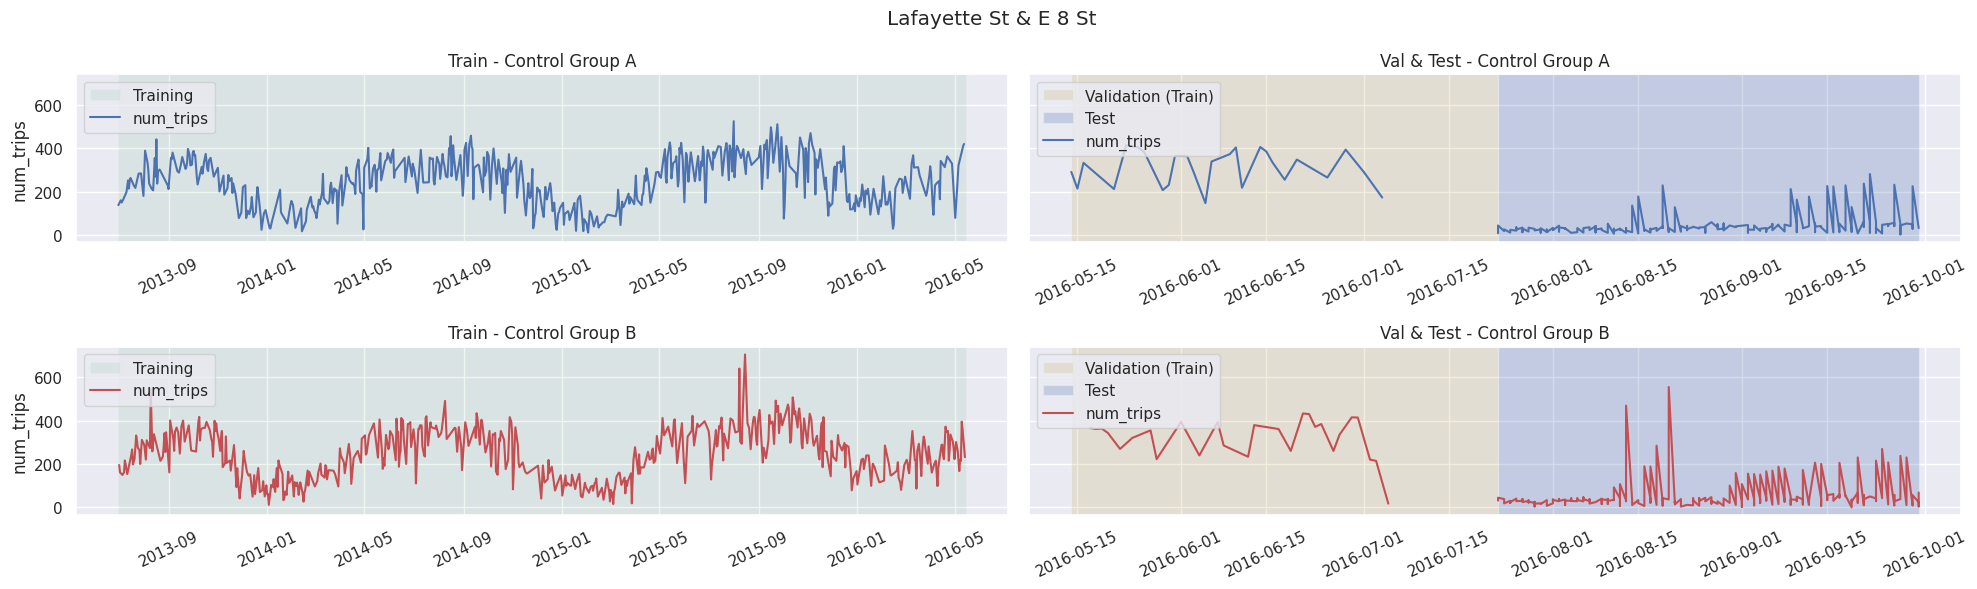

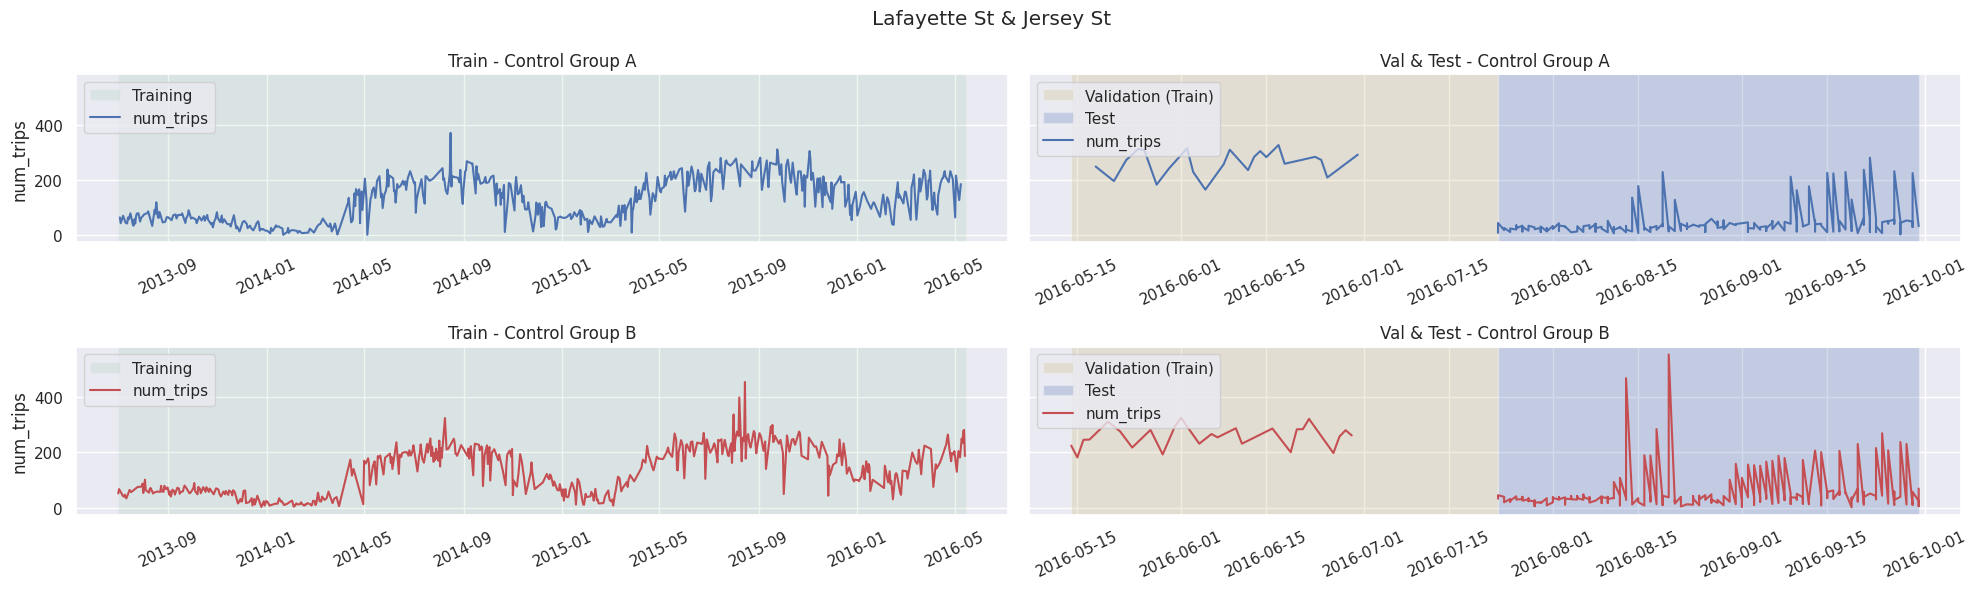

In [54]:
series = combined_df[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(2, 2, figsize=(20, 6), sharey=True) # sharex=True,
        fig.subplots_adjust(wspace=0)

        # control group b
        traindf_a = groupa_train[(groupa_train[SERIES_COLUMN] == st) & (groupa_train['splits'] == 'TRAIN')]
        valdf_a = groupa_train[(groupa_train[SERIES_COLUMN] == st) & (groupa_train['splits'] == 'VALIDATE')]
        # control group b
        traindf_b = groupb_train[(groupb_train[SERIES_COLUMN] == st) & (groupb_train['splits'] == 'TRAIN')]
        valdf_b = groupb_train[(groupb_train[SERIES_COLUMN] == st) & (groupb_train['splits'] == 'VALIDATE')]

        # regions
        axes[0,0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[0,1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[0,1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        
        axes[1,0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1,1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1,1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0, 0].plot(traindf_a[TIME_COLUMN], traindf_a[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[0, 0].set_title("Train - Control Group A")
        
        axes[1, 0].plot(traindf_b[TIME_COLUMN], traindf_b[TARGET_COLUMN], color = 'r', label = f'{TARGET_COLUMN}')
        axes[1, 0].sharex(axes[0, 0])
        axes[1, 0].set_title("Train - Control Group B")
        
        axes[0, 1].plot(valdf_a[TIME_COLUMN], valdf_a[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[0, 1].plot(group_a_series.index, group_a_series[TARGET_COLUMN], color = 'b')#, label = f'{TARGET_COLUMN}')
        axes[0, 1].set_title("Val & Test - Control Group A")
        
        axes[1, 1].plot(valdf_b[TIME_COLUMN], valdf_b[TARGET_COLUMN], color = 'r', label = f'{TARGET_COLUMN}')
        axes[1, 1].plot(group_b_series.index, group_b_series[TARGET_COLUMN], color = 'r')#, label = f'{TARGET_COLUMN}')
        axes[1, 1].sharex(axes[0, 1])
        axes[1, 1].set_title("Val & Test - Control Group B")
        
        # axes ticks
        axes[0, 0].tick_params(axis='x', rotation=25)
        axes[1, 0].tick_params(axis='x', rotation=25)
        axes[0, 1].tick_params(axis='x', rotation=25)
        axes[1, 1].tick_params(axis='x', rotation=25)
        
        # axes[0].plot(traindf_a[TIME_COLUMN], traindf_a[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        # axes[0].plot(traindf_b[TIME_COLUMN], traindf_b[TARGET_COLUMN], color = 'r', label = f'{TARGET_COLUMN}')
        # axes[1].plot(valdf_a[TIME_COLUMN], valdf_a[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        # axes[1].plot(valdf_b[TIME_COLUMN], valdf_b[TARGET_COLUMN], color = 'r', label = f'{TARGET_COLUMN}')
        # axes[1].plot(group_a_series.index, group_a_series[TARGET_COLUMN], color = 'b', label = 'group_a')
        # axes[1].plot(group_b_series.index, group_b_series[TARGET_COLUMN], color = 'r', label = 'group_b')

        # labels
        axes[0, 0].set_ylabel(TARGET_COLUMN)
        axes[0, 0].legend(loc = 'upper left')
        axes[1, 0].set_ylabel(TARGET_COLUMN)
        axes[1, 0].legend(loc = 'upper left')
        # axes[0, 1].set_ylabel(TARGET_COLUMN)
        axes[0, 1].legend(loc = 'upper left')
        # axes[1, 1].set_ylabel(TARGET_COLUMN)
        axes[1, 1].legend(loc = 'upper left')
        plt.suptitle(st)
        fig.tight_layout()

        # display result
        plt.show()